In [7]:
# A time series analysis of the stock performance for the top 5 American technology companies:
# AAPL = Apple
# AMZN = Amazon
# FB = Facebook
# GOOG = Google
# NFLX = Netflix

# Data source = https://www.kaggle.com/brianthecoder/historical-data-for-faang-stocks

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import math
from math import sqrt

# Load in dataframes
df_AAPL = pd.read_csv('/Users/levine_scholar/FAANG_Stock_History/AAPL.csv')
df_AMZN = pd.read_csv('/Users/levine_scholar/FAANG_Stock_History/AMZN.csv')
df_FB = pd.read_csv('/Users/levine_scholar/FAANG_Stock_History/FB.csv')
df_GOOG = pd.read_csv('/Users/levine_scholar/FAANG_Stock_History/GOOG.csv')
df_NFLX = pd.read_csv('/Users/levine_scholar/FAANG_Stock_History/NFLX.csv')

# Produce list of dataframes and dataframe names
dfs = [df_AAPL, df_AMZN, df_FB, df_GOOG, df_NFLX]
dfs_dict = {'AAPL': df_AAPL, 'AMZN': df_AMZN, 'FB': df_FB, 'GOOG': df_GOOG,'NFLX': df_NFLX}
df_names = list(dfs_dict.keys()) 

# Preview Data
df_AAPL.head()
#df_AMZN.head()
#df_FB.head()
#df_GOOG.head()
#df_NFLX.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2020-10-01,117.64,117.72,115.83,116.79,116.79,116120440,0.0,1.0
1,2020-09-30,113.79,117.26,113.62,115.81,115.81,142675184,0.0,1.0
2,2020-09-29,114.55,115.31,113.57,114.09,114.09,100060526,0.0,1.0
3,2020-09-28,115.01,115.32,112.78,114.96,114.96,137672403,0.0,1.0
4,2020-09-25,108.43,112.44,107.67,112.28,112.28,149981441,0.0,1.0


In [ ]:
# Determine the number of rows and columns in the data
i=0
for df in dfs:
    nRow, nCol = df.shape
    print(f'There are {nRow} rows and {nCol} columns in the '+ df_names[i] + ' Dataframe')
    i=i+1

In [8]:
# Check the data for any null values and determine data types

i = 0
for df in dfs:
    print('\033[1m' + 'Any Null Values in ' + df_names[i] + ' Dataframe Detected: '+ '\033[0m')
    print(df.isnull().values.any())
    print('\033[1m' + 'Data Types: '+ '\033[0m')
    print(df.dtypes)
    i = i+1 
     

Any Null Values in AAPL Dataframe Detected: 
False
Data Types: 
timestamp             object
open                 float64
high                 float64
low                  float64
close                float64
adjusted_close       float64
volume                 int64
dividend_amount      float64
split_coefficient    float64
dtype: object
Any Null Values in AMZN Dataframe Detected: 
False
Data Types: 
timestamp             object
open                 float64
high                 float64
low                  float64
close                float64
adjusted_close       float64
volume                 int64
dividend_amount      float64
split_coefficient    float64
dtype: object
Any Null Values in FB Dataframe Detected: 
False
Data Types: 
timestamp             object
open                 float64
high                 float64
low                  float64
close                float64
adjusted_close       float64
volume                 int64
dividend_amount      float64
split_coefficient    float64

In [9]:
# Convert timestamp to datetime format and add individual columns for year, month, and day

for df in dfs:
    dates = df['timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day

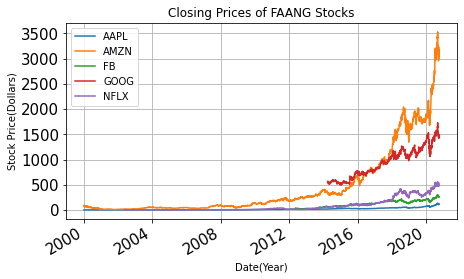

In [123]:
# General trends of closing prices

for df in dfs:
    close_price = df.groupby(['timestamp'])['adjusted_close'].mean()
    plt_close = close_price.plot(figsize=(7,4), title ='Closing Prices of FAANG Stocks', 
                                 xlabel='Date(Year)', ylabel='Stock Price(Dollars)', 
                                 fontsize=15,legend=True, grid=True,)
    plt_close.legend(df_names, fontsize=10)

The Average Maximum Close for AAPL takes place in month 9
The Average Maximum Close for AMZN takes place in month 9
The Average Maximum Close for FB takes place in month 9
The Average Maximum Close for GOOG takes place in month 8
The Average Maximum Close for NFLX takes place in month 7


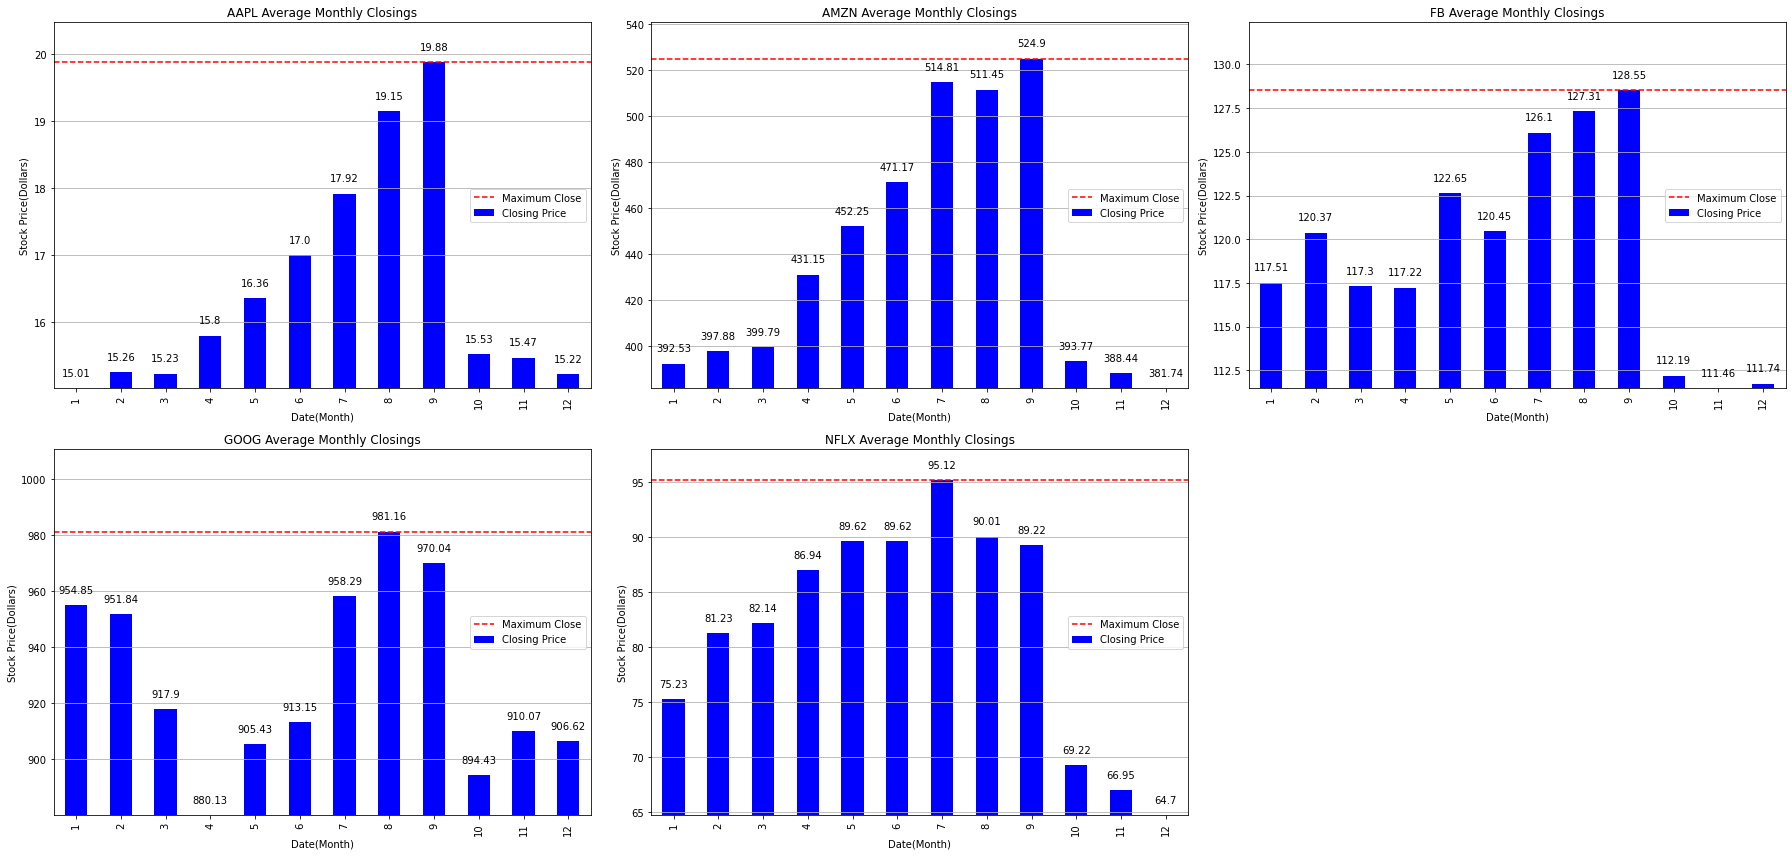

In [124]:
# Adjusted closing price averages for each month 
i = 0
for df in dfs:
    month_avg = df.groupby(['month'])['adjusted_close'].mean()
    max_month_avg = month_avg.max()
    min_month_avg = month_avg.min()  
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    print('The Average Maximum Close for ' + df_names[i] +  ' takes place in month ' + str(month_avg.idxmax())) 
    yp = month_avg.plot.bar(figsize=(25,12), color = 'b', 
                            title=df_names[i] + ' Average Monthly Closings', xlabel='Date(Month)', ylabel='Stock Price(Dollars)', label = 'Closing Price')
    plt.axhline(max_month_avg, color='r', linestyle='dashed', label="Maximum Close")
    plt.gca().yaxis.grid(True)
    plt.legend(loc='right')
    plt.ylim([min_month_avg,max_month_avg + max_month_avg * .03])
    for p in yp.patches:                
        yp.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 15), textcoords='offset points')
    i=i+1

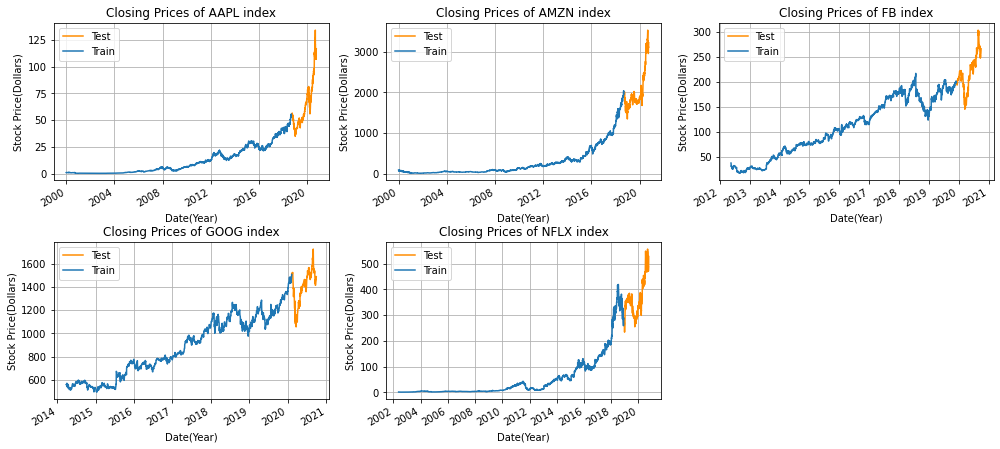

In [125]:
# Define the test(orange) and train(blue) data groups for forcast modeling
i=0
dfs_train = []
dfs_test = []
for df in dfs:
    v = int(len(df)-.9*len(df))
    test = df[:v]
    train = df[v-1:]
    test_close = test.groupby(['timestamp'])['adjusted_close'].mean()
    train_close = train.groupby(['timestamp'])['adjusted_close'].mean()
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt_test = test_close.plot(figsize=(14,7), title = 'Closing Prices of '+ df_names[i]+ ' index',
                               fontsize=10, legend = True, grid = True, color = "darkorange")
    plt_train = train_close.plot(figsize=(14,7), title='Closing Prices of '+ df_names[i] + ' index',
                                 fontsize=10, grid = True, xlabel = 'Date(Year)', ylabel = 'Stock Price(Dollars)')
    plt.legend(['Test', 'Train'])
    
    dfs_train.append(train)
    dfs_test.append(test)
    i=i+1


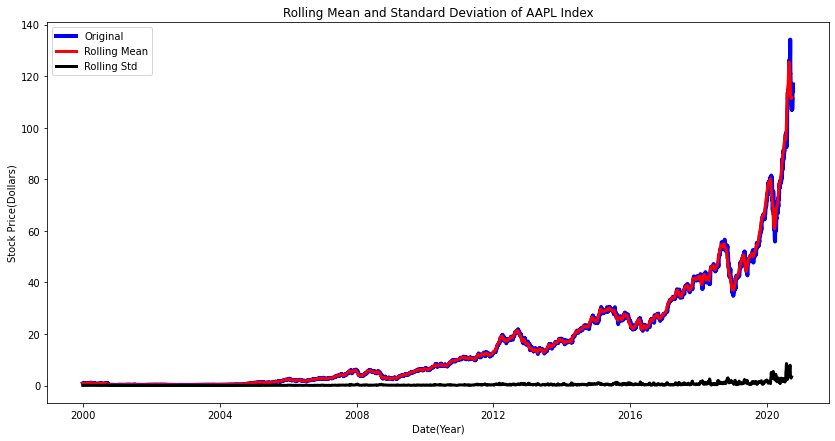

Results of Dickey Fuller Test:
Test Statistics                    -6.3509
p-value                        2.61246e-08
No. of lags used                        33
Number of observations used           5187
critical value (1%)                 -3.432
critical value (5%)                 -2.862
critical value (10%)                -2.567
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


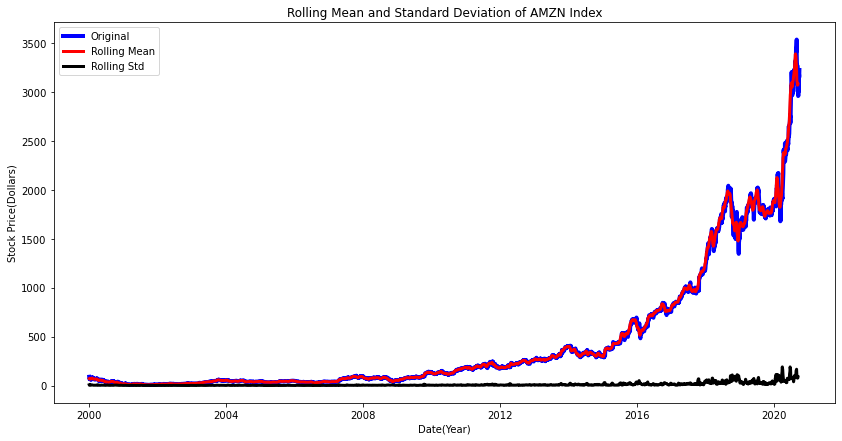

Results of Dickey Fuller Test:
Test Statistics                   -6.38741
p-value                        2.14718e-08
No. of lags used                        33
Number of observations used           5187
critical value (1%)                 -3.432
critical value (5%)                 -2.862
critical value (10%)                -2.567
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


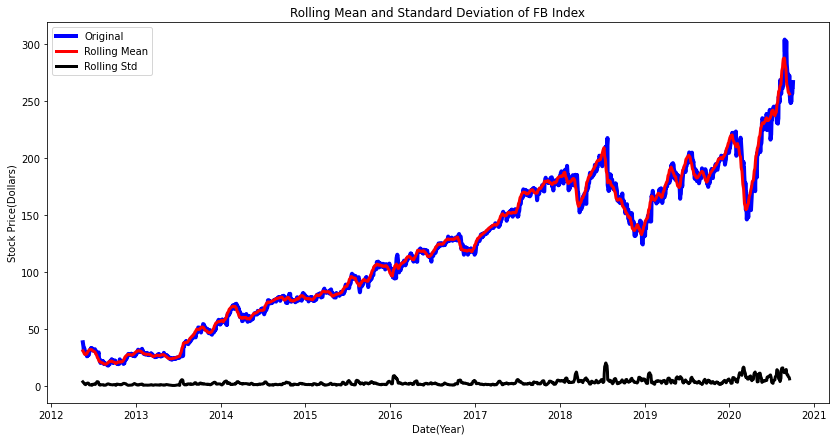

Results of Dickey Fuller Test:
Test Statistics                 -2.67819
p-value                        0.0778891
No. of lags used                      24
Number of observations used         2082
critical value (1%)               -3.433
critical value (5%)               -2.863
critical value (10%)              -2.568
dtype: object
Test Statistic > critical value (5%) and p-value > 5% 
Therefore, accept the null hypothesis (Data is non-stationary)


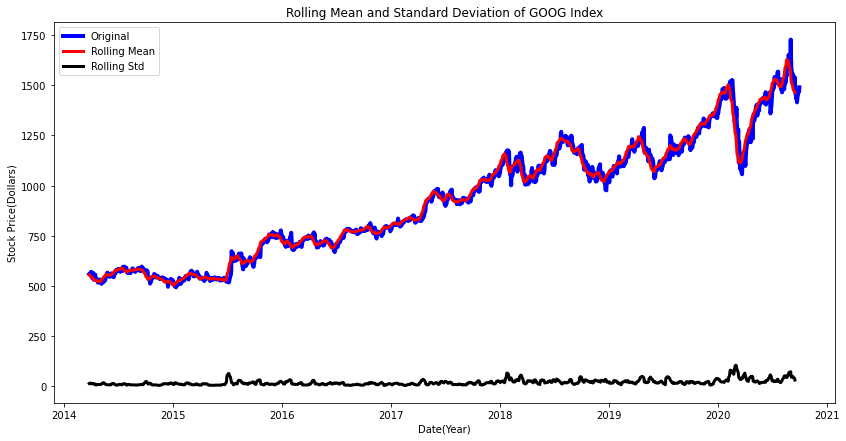

Results of Dickey Fuller Test:
Test Statistics               -2.10732
p-value                        0.24158
No. of lags used                    22
Number of observations used       1619
critical value (1%)             -3.434
critical value (5%)             -2.863
critical value (10%)            -2.568
dtype: object
Test Statistic > critical value (5%) and p-value > 5% 
Therefore, accept the null hypothesis (Data is non-stationary)


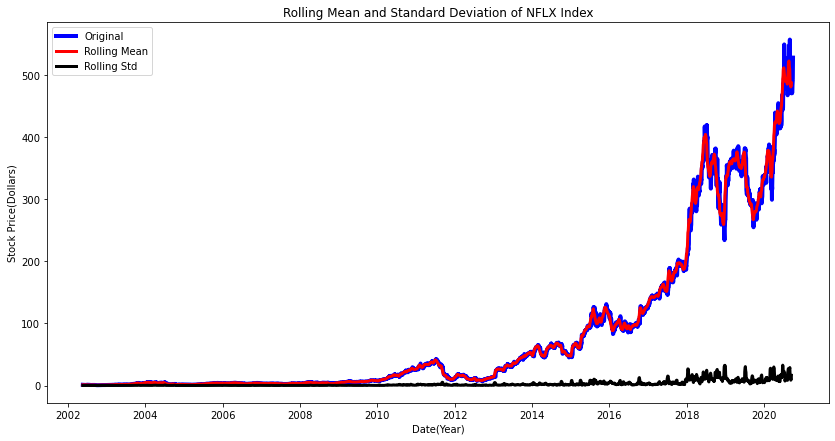

Results of Dickey Fuller Test:
Test Statistics                  -3.89883
p-value                        0.00204348
No. of lags used                       32
Number of observations used          4590
critical value (1%)                -3.432
critical value (5%)                -2.862
critical value (10%)               -2.567
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


In [126]:
# Check to see if data is stationary by employing the Dickey Fuller Test

def test_stationarity(timeseries):
    # Determing rolling statistics
    roll_mean = timeseries.rolling(12).mean()
    roll_std = timeseries.rolling(12).std()
    
    # Plot rolling statistics:
    plt.figure(figsize=(14,7)) 
    plt.plot(timeseries, color='blue',label='Original', linewidth=4) 
    plt.plot(roll_mean, color='red', label='Rolling Mean', linewidth=3) 
    plt.plot(roll_std, color='black', label='Rolling Std', linewidth=3) 
    plt.legend(loc='best')
    plt.xlabel('Date(Year)')
    plt.ylabel('Stock Price(Dollars)')
    plt.title('Rolling Mean and Standard Deviation of '+ df_names[i] +' Index' )
    #plt.title('Rolling Mean and Standard Deviation') 
    plt.show()
    
    print('\033[1m' + 'Results of Dickey Fuller Test:'+ '\033[0m')
    info_df = adfuller(timeseries, autolag='AIC')
    
    # Summarize the Dickey Fuller Test and print results 
    output = pd.Series(info_df[0:4],index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used']) 
    for key,values in info_df[4].items():
        output['critical value (%s)'% key] = f"{values:.3f}"
    print(output)
    if output['p-value'] > .05:
        print('Test Statistic > critical value (5%) and p-value > 5% \nTherefore, accept the null hypothesis (Data is non-stationary)')
    else:
        print('Test Statistic < critical value (5%) and p-value < 5% \nTherefore, reject the null hypothesis (Data is stationary)')
i=0
for df in dfs:
    test_stationarity(df['adjusted_close'])
    i=i+1

Presence of Null Values:
True



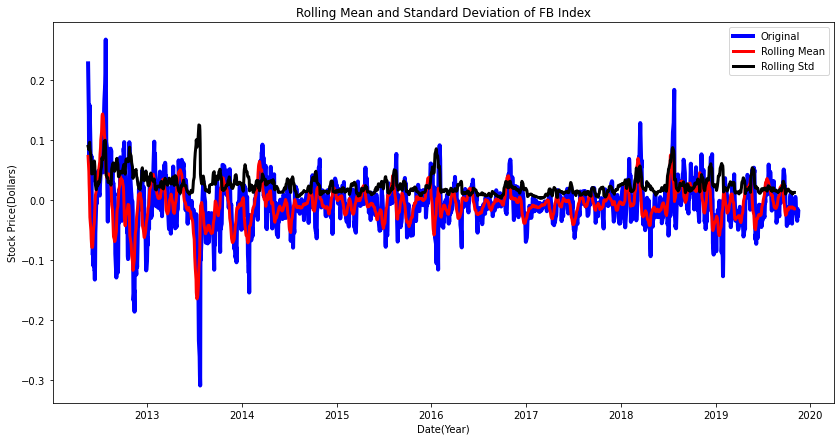

Results of Dickey Fuller Test:
Test Statistics                    -8.8661
p-value                        1.43909e-14
No. of lags used                        11
Number of observations used           1875
critical value (1%)                 -3.434
critical value (5%)                 -2.863
critical value (10%)                -2.568
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)

Presence of Null Values:
True



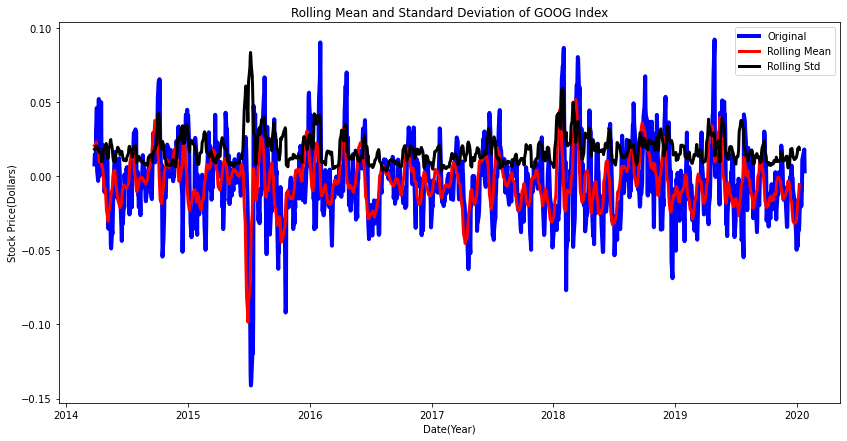

Results of Dickey Fuller Test:
Test Statistics                  -8.86444
p-value                        1.4532e-14
No. of lags used                       11
Number of observations used          1456
critical value (1%)                -3.435
critical value (5%)                -2.864
critical value (10%)               -2.568
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


In [127]:
# FB and GOOG should be transformed to stationary by removing the trend and seasonality of the data
dfs_train_log = []
dfs_test_log = []
for df in dfs_train: 
    train_log = np.log(df['adjusted_close'])
    dfs_train_log.append(train_log)
for df in dfs_test:
    test_log = np.log(df['adjusted_close'])
    dfs_test_log.append(test_log)

train_log_FB = dfs_train_log[2]
test_log_FB = dfs_test_log[2]

train_log_GOOG = dfs_train_log[3]
test_log_GOOG = dfs_test_log[3]

train_log_ma_FB = train_log_FB.rolling(12).mean() 
test_log_ma_FB = test_log_FB.rolling(12).mean() 

train_log_ma_GOOG = train_log_GOOG.rolling(12).mean() 
test_log_ma_GOOG = test_log_GOOG.rolling(12).mean() 

train_log_ma_diff_FB = train_log_FB - train_log_ma_FB
train_log_ma_diff_GOOG = train_log_GOOG - train_log_ma_GOOG

# moving average of 12 values produces 11 null values 
print("Presence of Null Values:")
print(train_log_ma_diff_FB.isnull().values.any())
print()

i = 2
train_log_ma_diff_FB.dropna(inplace = True)
test_stationarity(train_log_ma_diff_FB)

print()
print("Presence of Null Values:")
print(train_log_ma_diff_GOOG.isnull().values.any())
print()

i = 3
train_log_ma_diff_GOOG.dropna(inplace = True)
test_stationarity(train_log_ma_diff_GOOG)

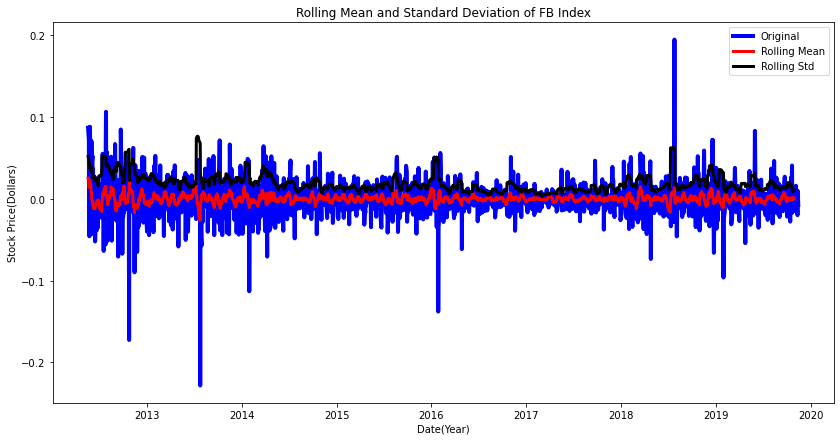

Results of Dickey Fuller Test:
Test Statistics                   -13.1719
p-value                        1.24556e-24
No. of lags used                        21
Number of observations used           1864
critical value (1%)                 -3.434
critical value (5%)                 -2.863
critical value (10%)                -2.568
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


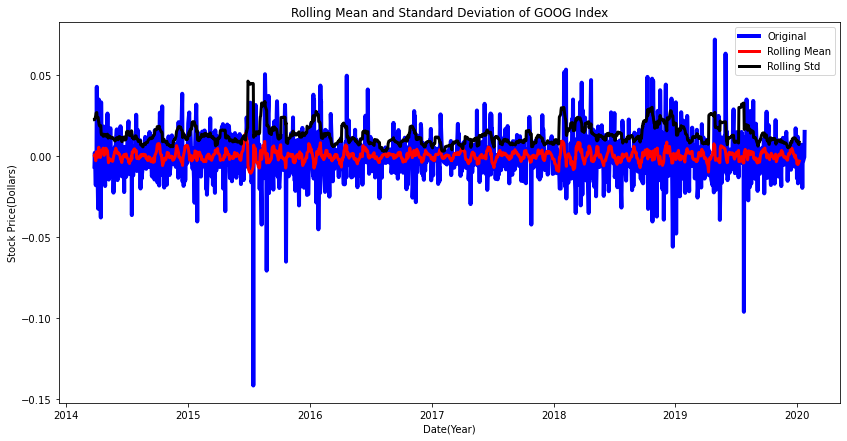

Results of Dickey Fuller Test:
Test Statistics                 -16.1696
p-value                        4.379e-29
No. of lags used                      14
Number of observations used         1452
critical value (1%)               -3.435
critical value (5%)               -2.864
critical value (10%)              -2.568
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


In [128]:
# Stabilize the mean and eliminate more trend in the timeseries by differencing

i = 2
train_log_ma_diff_FB = train_log_ma_diff_FB - train_log_ma_diff_FB.shift(periods = 1) 
train_log_ma_diff2_FB = train_log_ma_diff_FB.dropna()
test_stationarity(train_log_ma_diff2_FB)

i = 3
train_log_ma_diff_GOOG = train_log_ma_diff_GOOG - train_log_ma_diff_GOOG.shift(periods = 1) 
train_log_ma_diff2_GOOG = train_log_ma_diff_GOOG.dropna()
test_stationarity(train_log_ma_diff2_GOOG)

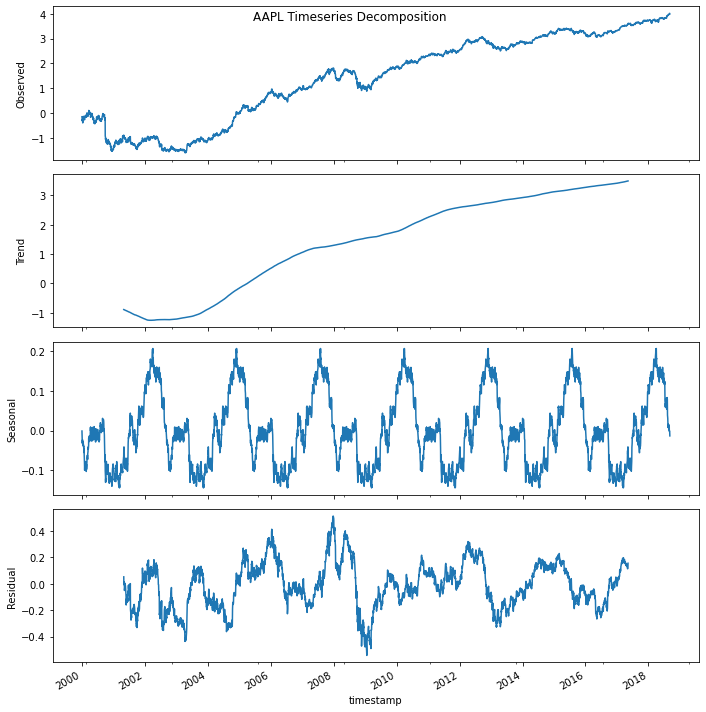

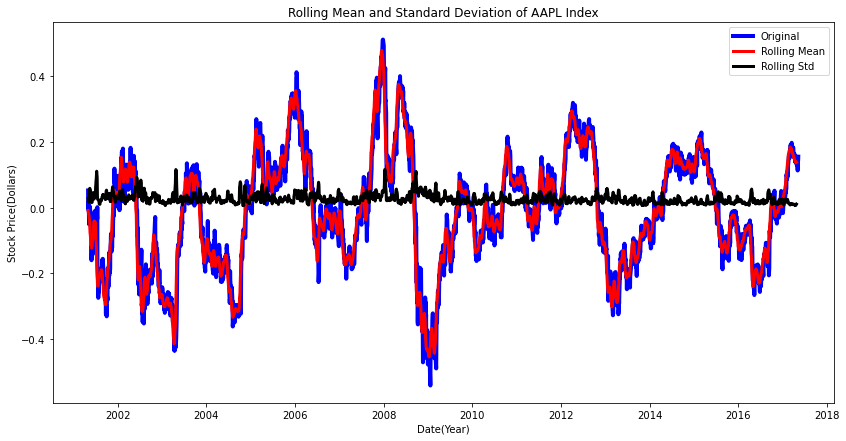

Results of Dickey Fuller Test:
Test Statistics                 -3.91966
p-value                        0.0018948
No. of lags used                       4
Number of observations used         4025
critical value (1%)               -3.432
critical value (5%)               -2.862
critical value (10%)              -2.567
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


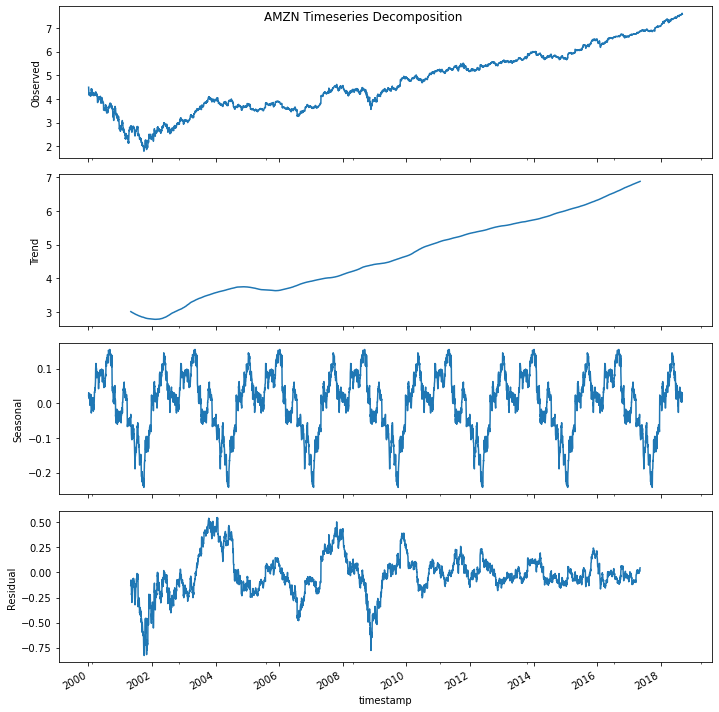

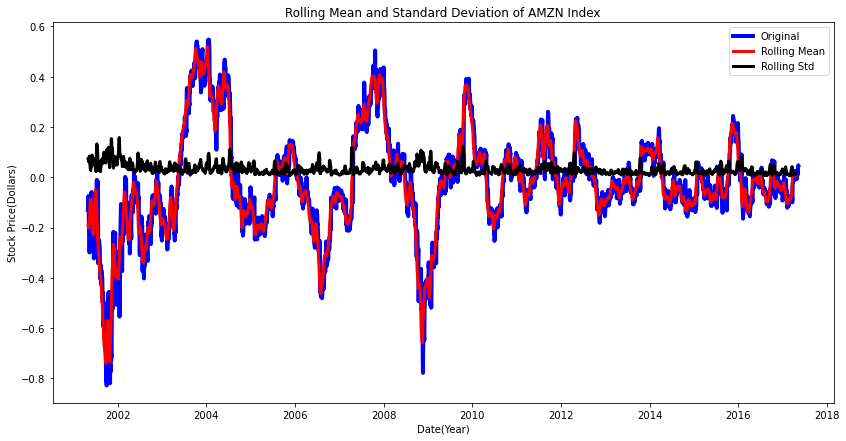

Results of Dickey Fuller Test:
Test Statistics                   -3.5893
p-value                        0.00596887
No. of lags used                       18
Number of observations used          4011
critical value (1%)                -3.432
critical value (5%)                -2.862
critical value (10%)               -2.567
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


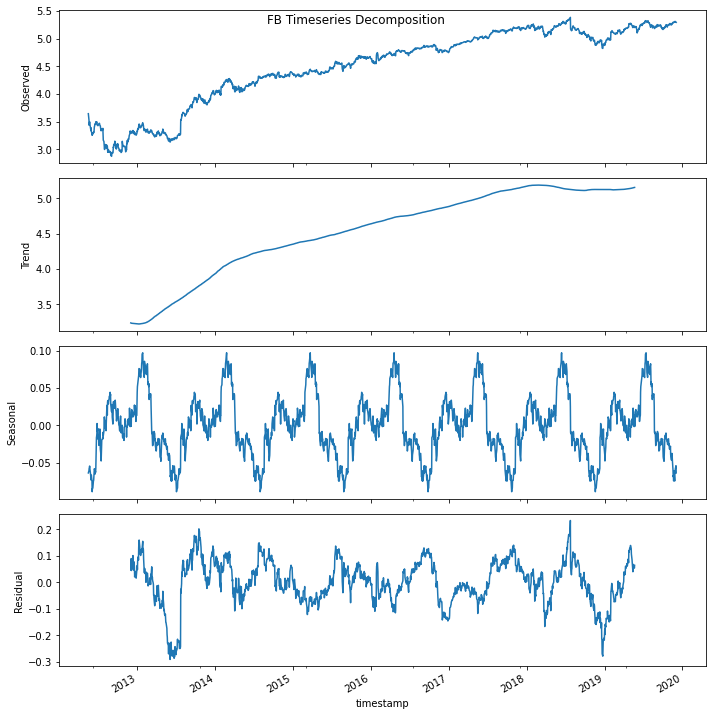

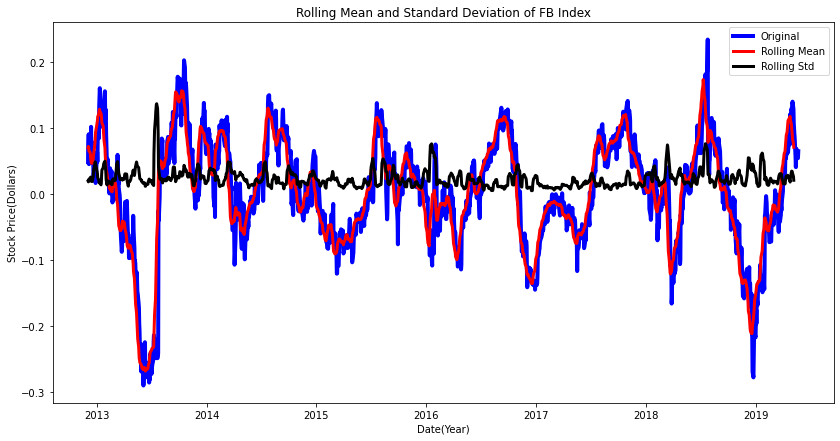

Results of Dickey Fuller Test:
Test Statistics                 -4.56433
p-value                        0.0001502
No. of lags used                       0
Number of observations used         1627
critical value (1%)               -3.434
critical value (5%)               -2.863
critical value (10%)              -2.568
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


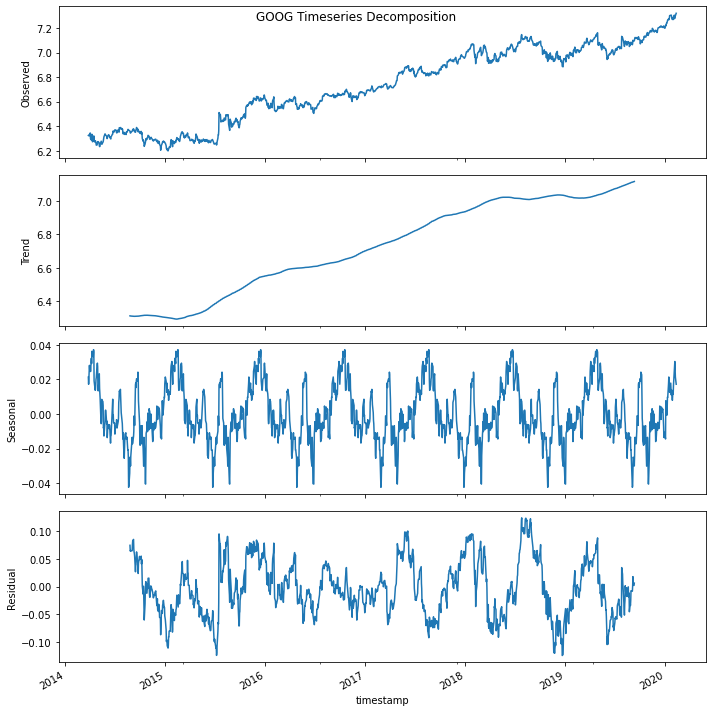

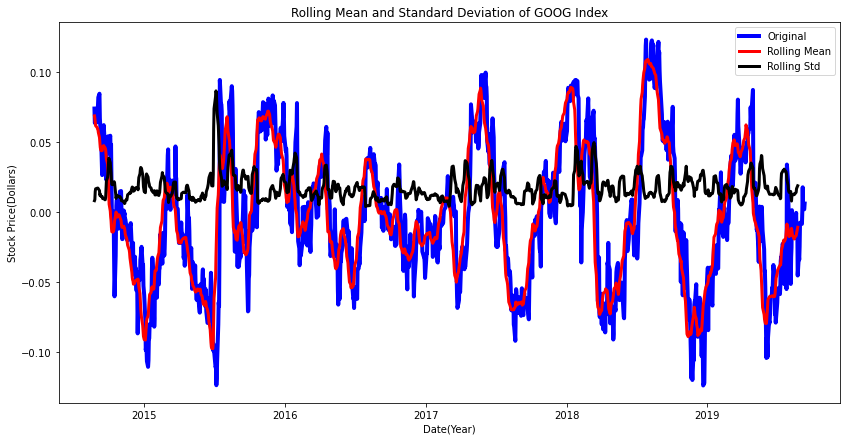

Results of Dickey Fuller Test:
Test Statistics                   -4.60723
p-value                        0.000125265
No. of lags used                        18
Number of observations used           1250
critical value (1%)                 -3.436
critical value (5%)                 -2.864
critical value (10%)                -2.568
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


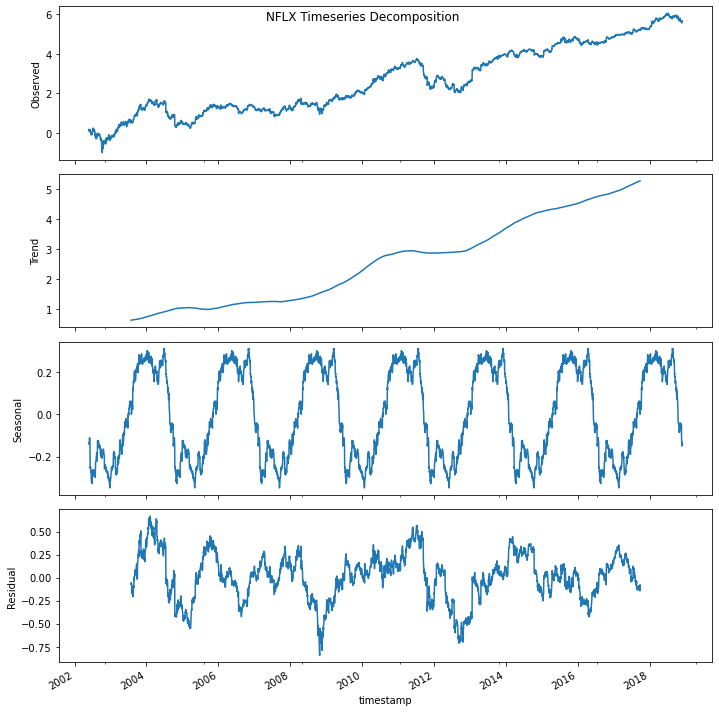

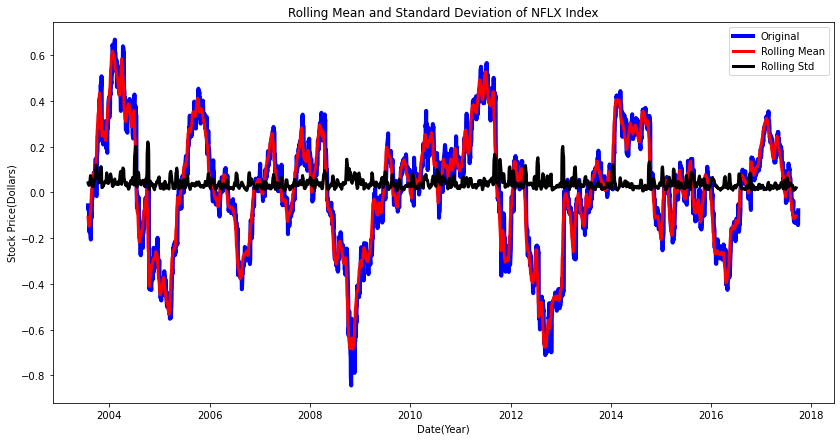

Results of Dickey Fuller Test:
Test Statistics                  -4.08149
p-value                        0.00103905
No. of lags used                        1
Number of observations used          3566
critical value (1%)                -3.432
critical value (5%)                -2.862
critical value (10%)               -2.567
dtype: object
Test Statistic < critical value (5%) and p-value < 5% 
Therefore, reject the null hypothesis (Data is stationary)


In [129]:
# Remove seasonality and decomposing the time series into trend, seasonality, and residuals
# Weekly seasonality assumed

weeks = []
for df in dfs_train:
    day_count = len(df['day'])
    week_count = day_count/7
    weeks.append(week_count)

i = 0
for df in dfs_train_log:
    result = seasonal_decompose(df, model = 'additive', freq = int(weeks[i]))
    plt.rc("figure", figsize=(10,10))
    yd = result.plot()
    yd.suptitle(df_names[i] + ' Timeseries Decomposition')
 
    #Check if residuals are stationary
    df_train_log_residual =  pd.Series(result.resid)
    df_train_log_residual.dropna(inplace = True)
    test_stationarity(df_train_log_residual)
    i=i+1


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-20649.310, BIC=-20610.579, Fit time=3.001 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-20652.873, BIC=-20639.963, Fit time=0.429 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-20654.532, BIC=-20635.167, Fit time=0.465 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-20654.545, BIC=-20635.180, Fit time=0.452 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-20652.517, BIC=-20626.697, Fit time=0.911 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-20652.504, BIC=-20626.683, Fit time=0.643 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-20650.516, BIC=-20618.240, Fit time=0.872 seconds
Total fit time: 6.776 seconds


/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:293: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  stop = base_index._start + (key + 1) * base_index._step
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:293: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  stop = base_index._start + (key + 1) * base_index._step
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:294: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  index = RangeIndex(start=base_index._start,
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:296: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use Ra

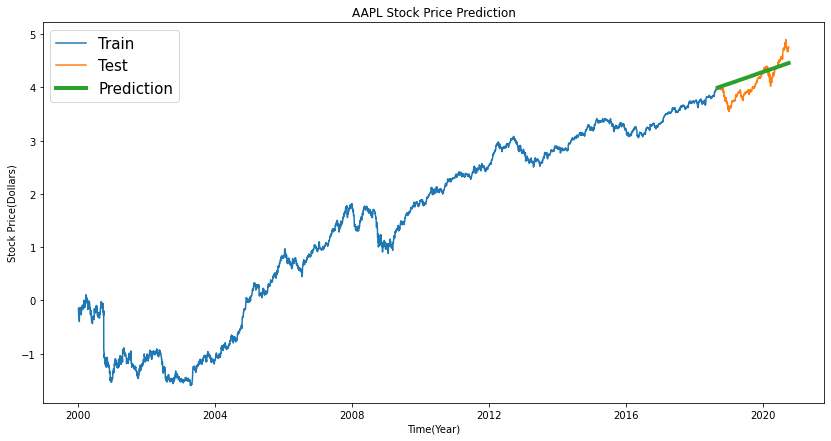

Model RMSE:  0.23632793084455353
Model RMSE is close to 0 so it is a good fit

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-18689.037, BIC=-18650.306, Fit time=1.615 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-18685.906, BIC=-18672.996, Fit time=0.802 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-18683.996, BIC=-18664.630, Fit time=0.375 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-18684.005, BIC=-18664.640, Fit time=1.954 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-18690.216, BIC=-18657.940, Fit time=4.351 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-18681.975, BIC=-18656.155, Fit time=1.166 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=-18689.447, BIC=-18650.716, Fit time=3.615 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=-18688.575, BIC=-18643.390, Fit time=2.112 seconds
Fit ARIMA: order=(0, 1, 2) season

/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:293: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  stop = base_index._start + (key + 1) * base_index._step
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:293: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  stop = base_index._start + (key + 1) * base_index._step
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:294: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  index = RangeIndex(start=base_index._start,
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:296: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use Ra

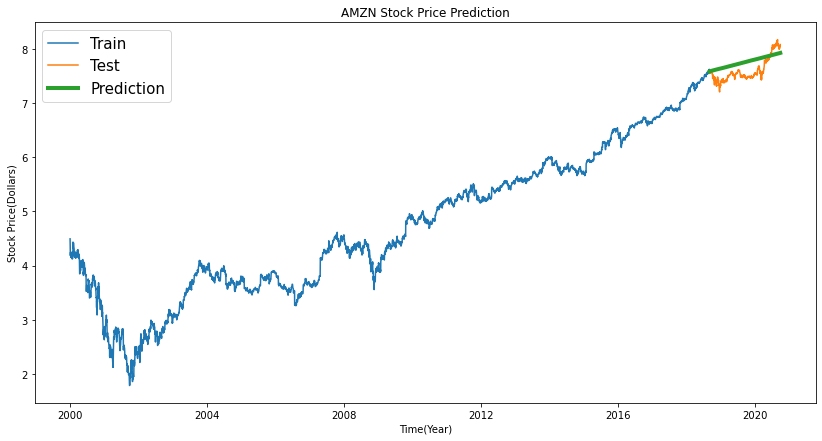

Model RMSE:  0.21367697623231022
Model RMSE is close to 0 so it is a good fit

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-8985.414, BIC=-8974.318, Fit time=0.245 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-8983.522, BIC=-8966.878, Fit time=0.202 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-8983.521, BIC=-8966.877, Fit time=0.427 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.882 seconds


/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:293: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  stop = base_index._start + (key + 1) * base_index._step
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:293: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  stop = base_index._start + (key + 1) * base_index._step
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:294: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  index = RangeIndex(start=base_index._start,
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:296: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use Ra

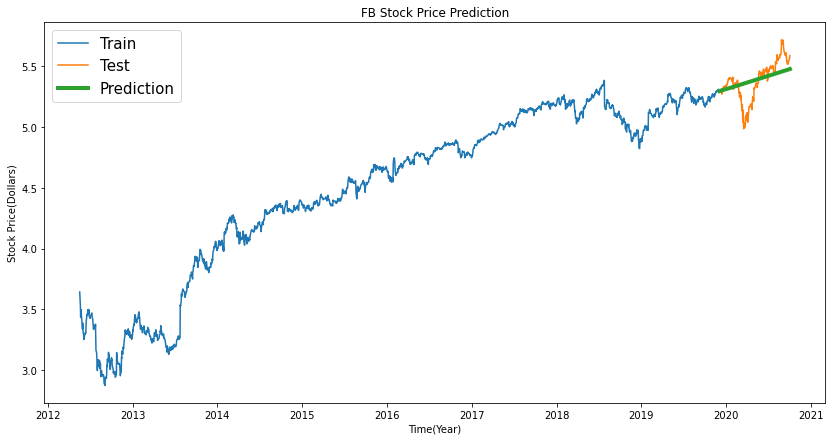

Model RMSE:  0.13125572279227696
Model RMSE is close to 0 so it is a good fit

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-8259.340, BIC=-8248.743, Fit time=0.149 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-8258.138, BIC=-8242.243, Fit time=0.148 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-8258.239, BIC=-8242.344, Fit time=0.534 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-8256.985, BIC=-8235.791, Fit time=0.439 seconds
Total fit time: 1.276 seconds


/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:293: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  stop = base_index._start + (key + 1) * base_index._step
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:293: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  stop = base_index._start + (key + 1) * base_index._step
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:294: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  index = RangeIndex(start=base_index._start,
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:296: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use Ra

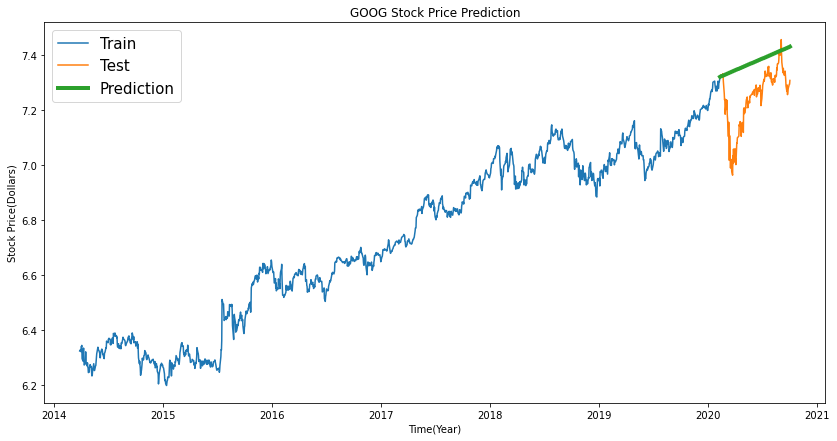

Model RMSE:  0.15759038162621664
Model RMSE is close to 0 so it is a good fit

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-15532.600, BIC=-15494.599, Fit time=4.923 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-15530.472, BIC=-15517.805, Fit time=0.469 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-15535.586, BIC=-15516.586, Fit time=0.382 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-15535.859, BIC=-15516.859, Fit time=1.789 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-15535.825, BIC=-15510.490, Fit time=1.080 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-15535.310, BIC=-15509.976, Fit time=0.934 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-15534.129, BIC=-15502.461, Fit time=1.331 seconds
Total fit time: 10.913 seconds


/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:293: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  stop = base_index._start + (key + 1) * base_index._step
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:293: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use RangeIndex.step instead
  stop = base_index._start + (key + 1) * base_index._step
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:294: FutureWarning: RangeIndex._start is deprecated and will be removed in a future version. Use RangeIndex.start instead
  index = RangeIndex(start=base_index._start,
/Users/levine_scholar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:296: FutureWarning: RangeIndex._step is deprecated and will be removed in a future version. Use Ra

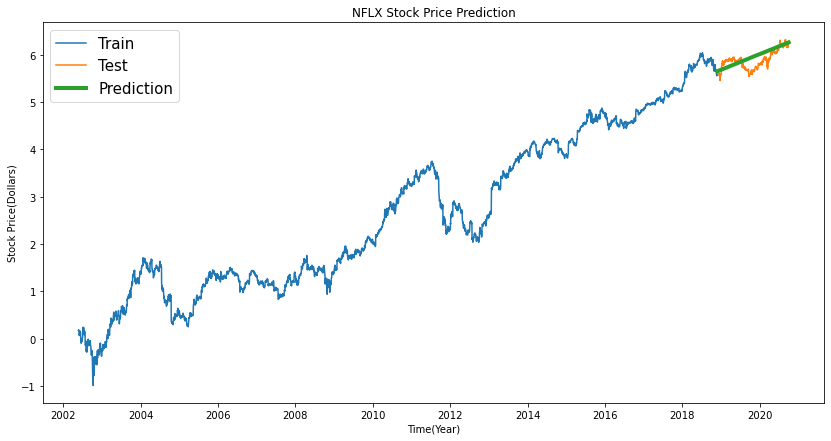

Model RMSE:  0.1655855667505073
Model RMSE is close to 0 so it is a good fit



In [133]:
# Forecast the stock prices using an ARIMA model

dfs_train_log_rev = []
dfs_test_log_rev = []

for df in dfs_train_log:
    train_log_rev = df.iloc[::-1]
    dfs_train_log_rev.append(train_log_rev)
for df in dfs_test_log:
    test_log_rev = df.iloc[::-1]
    dfs_test_log_rev.append(test_log_rev)
for i in range(5):
        model = auto_arima(dfs_train_log_rev[i], trace=True, error_action='ignore', suppress_warnings=True)
        model.fit(dfs_train_log_rev[i])
        
        forecast = model.predict(n_periods=len(dfs_test_log_rev[i]))
        forecast = pd.DataFrame(forecast,index = dfs_test_log_rev[i].index,columns = ['Prediction']) 

# plot the predictions for validation set 
        plt.figure(figsize=(14,7)) 
        plt.plot(dfs_train_log_rev[i], label='Train') 
        plt.plot(dfs_test_log_rev[i], label='Test') 
        plt.plot(forecast, label='Prediction', linewidth = 4) 
        plt.title(df_names[i] + ' Stock Price Prediction') 
        plt.xlabel('Time(Year)')
        plt.ylabel('Stock Price(Dollars)') 
        plt.legend(loc='upper left', fontsize=15) 
        plt.show()
        
# Use Root Mean Square Error to assess the forecast results
        rms = sqrt(mean_squared_error(dfs_test_log_rev[i],forecast)) 
        print("Model RMSE: ", rms)
        if rms < .25:
            print('Model RMSE is close to 0 so it is a good fit')
            print()
        else:
            print('Model RMSE is far from 0 so it is a poor fit')
            print()